<a href="https://colab.research.google.com/github/vmavis/colab/blob/main/image_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Preprocessing**

Before we try downloading our data set, we should upload our kaggle.json file and try accessing it.

In [ ]:
# !pip install kaggle
# !mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

We download it by inputting the name of the dataset shown in Kaggle.

In [ ]:
!kaggle datasets download -d miljan/stanford-dogs-dataset-traintest

stanford-dogs-dataset-traintest.zip: Skipping, found more recently modified local copy (use --force to force download)


We unzip the data we've downloaded from Kaggle.

In [ ]:
!unzip stanford-dogs-dataset-traintest.zip

Archive:  stanford-dogs-dataset-traintest.zip
replace cropped/cropped/test/n02085620-Chihuahua/n02085620_10074.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


We import all the necessary libraries and functions to run our code.

In [ ]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import glob
from tqdm import tqdm

We create a class to read the images we've downloaded.

In [ ]:
class Dataset(Dataset):
    def __init__(self, image_paths, transform=False):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = class_to_idx[label]
        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label


    def get_labels(self, idx):
      image_filepath = self.image_paths[idx]
      label = image_filepath.split('/')[-2]
      label = class_to_idx[label]
      return label

We obtain all the images from the train and test folders. We then split the train images into training and validation sets. We also check the number of images in each set.

In [ ]:
train_data_path = 'cropped/train'
test_data_path = 'cropped/test'

train_image_paths = []
classes = []

for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1])
    train_image_paths.append(glob.glob(data_path + '/*'))

train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

train_image_paths, valid_image_paths = train_image_paths[:int(0.7*len(train_image_paths))], train_image_paths[int(0.7*len(train_image_paths)):]

test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

train_image_path example:  cropped/train/n02099849-Chesapeake_Bay_retriever/n02099849_3203.jpg
class example:  n02086079-Pekinese
Train size: 8400
Valid size: 3600
Test size: 8580


We check the number of classes.

In [ ]:
print(len(classes))

120


We convert the class names into numbers for easier computing.

In [ ]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key,value in idx_to_class.items()}
print(class_to_idx)

{'n02086079-Pekinese': 0, 'n02111129-Leonberg': 1, 'n02089078-black-and-tan_coonhound': 2, 'n02091032-Italian_greyhound': 3, 'n02112706-Brabancon_griffon': 4, 'n02110063-malamute': 5, 'n02093859-Kerry_blue_terrier': 6, 'n02098413-Lhasa': 7, 'n02104365-schipperke': 8, 'n02102973-Irish_water_spaniel': 9, 'n02108422-bull_mastiff': 10, 'n02097658-silky_terrier': 11, 'n02110958-pug': 12, 'n02109961-Eskimo_dog': 13, 'n02106030-collie': 14, 'n02101388-Brittany_spaniel': 15, 'n02105505-komondor': 16, 'n02115641-dingo': 17, 'n02108551-Tibetan_mastiff': 18, 'n02105251-briard': 19, 'n02092339-Weimaraner': 20, 'n02100735-English_setter': 21, 'n02105855-Shetland_sheepdog': 22, 'n02086646-Blenheim_spaniel': 23, 'n02090379-redbone': 24, 'n02111277-Newfoundland': 25, 'n02113023-Pembroke': 26, 'n02085782-Japanese_spaniel': 27, 'n02113978-Mexican_hairless': 28, 'n02099849-Chesapeake_Bay_retriever': 29, 'n02112137-chow': 30, 'n02095570-Lakeland_terrier': 31, 'n02112350-keeshond': 32, 'n02106382-Bouvier_d

We transform each image to desired size, color, scale, etc.

In [ ]:
train_transforms = A.Compose(
    [
        A.Resize (height=32, width=32),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.Resize (height=32, width=32),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

We assign each training, validation, and testing variables to different data sets. We use DataLoader to create batch sizes and shuffle the data.

In [ ]:
train_dataset = Dataset(train_image_paths,train_transforms)
valid_dataset = Dataset(valid_image_paths,train_transforms)
test_dataset = Dataset(test_image_paths,test_transforms)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

We visualise a few random images from our training set.

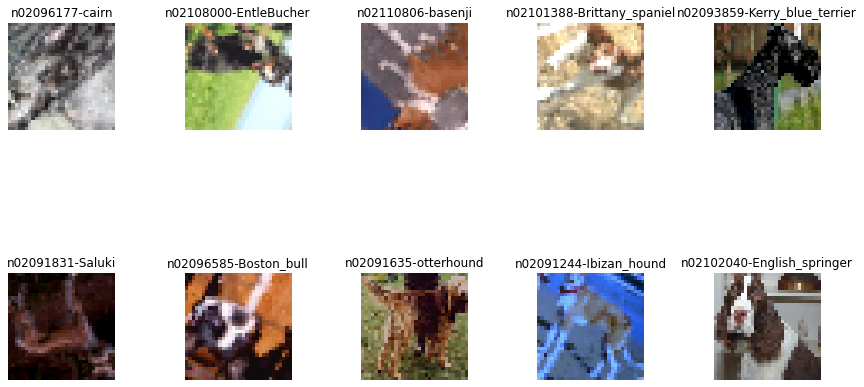

In [ ]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):

    dataset = copy.deepcopy(dataset)
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols


    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(train_image_paths))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

# **Convolutional Neural Network**

We create a neural network architecture to train our model.

In [ ]:
class Net1(nn.Module):
    def __init__(self, num_classes=120):
        super(Net1, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Linear(1024, 64),
            nn.ReLU())
        self.fc2 = nn.Sequential(
            nn.Linear(64, 10),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(10,120),
            nn.Softmax())

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

We create a variable to define our neural network, loss function, and optimizer.

In [ ]:
net1 = Net1()
criterion1 = nn.CrossEntropyLoss()
optimizer1 = torch.optim.SGD(net1.parameters(), lr=0.01)

We train our data and set our epoch to 5. We then check our training and validation loss.

In [ ]:
epochs = 5

train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):
    #===============================================================
    # training
    train_losses = []

    print("=========================================================")
    print("Epoch {}".format(i))

    for iteration, batch_data in enumerate(train_loader):
        x_batch, y_batch = batch_data

        optimizer1.zero_grad()

        out = net1(x_batch)
        loss = criterion1(out, y_batch.squeeze())

        loss.backward()
        optimizer1.step()

        train_losses.append(loss)

    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))

    train_mean_losses.append(train_mean_loss)

    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            x_batch, y_batch = batch_data

            out = net1(x_batch)
            loss = criterion1(out, y_batch.squeeze())
            valid_losses.append(loss)

        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))

        valid_mean_losses.append(valid_mean_loss)

        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net1.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================


Epoch 0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


training loss: 4.78749847
validation loss: 4.78748035
Epoch 1
training loss: 4.78750038
validation loss: 4.78749609
Epoch 2
training loss: 4.78749847
validation loss: 4.78747606
Epoch 3
training loss: 4.78749275
validation loss: 4.78748083
Epoch 4
training loss: 4.78750038
validation loss: 4.78748131


We plot our training and validation loss.

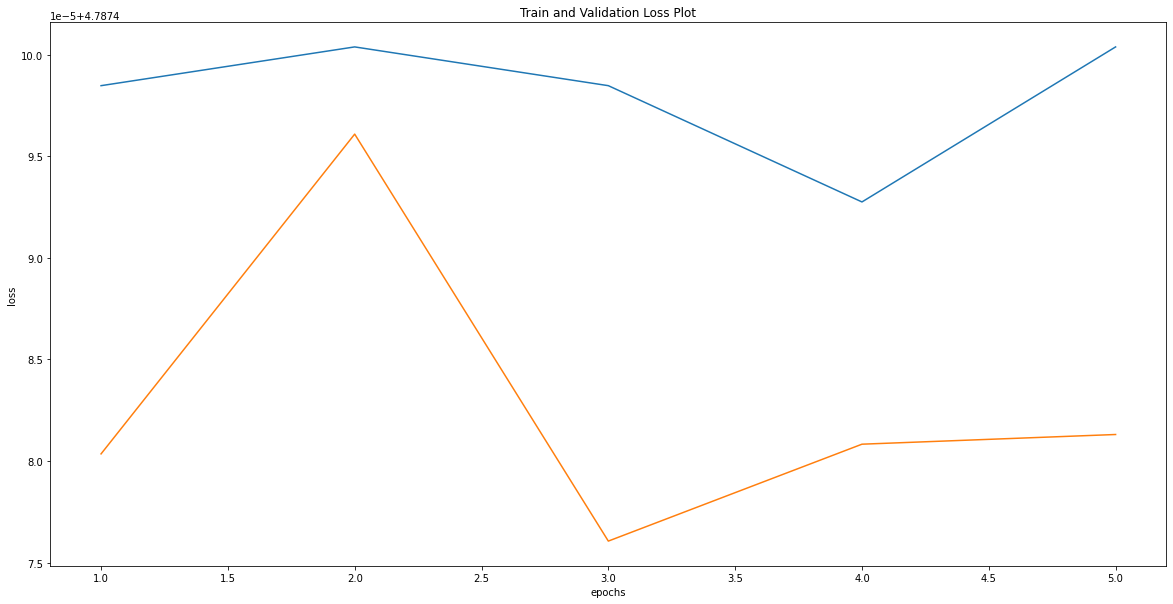

2 4.787500381469727


In [ ]:
plt.figure(figsize=(20,10))
t = [i.item() for i in train_mean_losses]
plt.plot(range(1,epochs+1), t)
v = [j.item() for j in valid_mean_losses]
plt.plot(range(1,epochs+1), v)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()
max_y = max(t)
max_x = range(1,epochs+1)[t.index(max_y)]
print(max_x, max_y)

We assign the accuracy of the first model to a variable.

In [ ]:
test_acc = 0
net1.eval()

with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        out = net1(x_batch)
        _, y_pred = torch.max(out.data, 1)
        test_acc += (y_pred==y_batch).sum().item()

    accuracy1 = round(100*test_acc/len(test_dataset), 8)

# **Architecture Modification and Hypertuning**

We create a new neural network architecture with a few additional layers to train our model. MaxPool scales down the data to aggregate information. BatchNorm makes sure the values of hidden layers have standardized mean and variance. Dropout removes random neurons to reduce overfitting.

In [ ]:
class Net2(nn.Module):
    def __init__(self, num_classes=120):
        super(Net2, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(32))
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.BatchNorm2d(64))
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64))
        self.fc2 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(64, 10),
            nn.ReLU())
        self.fc3 = nn.Sequential(
            nn.Linear(10,120),
            nn.Softmax())

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

We create a variable to define our neural network, loss function, and optimizer.

In [ ]:
net2 = Net2()
criterion2 = nn.CrossEntropyLoss()
optimizer2 = torch.optim.SGD(net2.parameters(), lr=0.01)

We train our data and keep our epoch as 5. We then check our training and validation loss.

In [ ]:
epochs = 5

train_mean_losses = []
valid_mean_losses = []

valid_best_loss = np.inf

for i in range(epochs):
    #===============================================================
    # training
    train_losses = []

    print("=========================================================")
    print("Epoch {}".format(i))

    for iteration, batch_data in enumerate(train_loader):
        x_batch, y_batch = batch_data

        optimizer2.zero_grad()

        out = net2(x_batch)
        loss = criterion1(out, y_batch.squeeze())

        loss.backward()
        optimizer2.step()

        train_losses.append(loss)

    train_mean_loss = torch.mean(torch.stack(train_losses))
    print('training loss: {:10.8f}'.format(train_mean_loss))

    train_mean_losses.append(train_mean_loss)

    #===============================================================
    # validation
    valid_losses = []
    with torch.set_grad_enabled(False):
        for iteration, batch_data in enumerate(valid_loader):
            x_batch, y_batch = batch_data

            out = net2(x_batch)
            loss = criterion1(out, y_batch.squeeze())
            valid_losses.append(loss)

        valid_mean_loss = torch.mean(torch.stack(valid_losses))
        print('validation loss: {:10.8f}'.format(valid_mean_loss))

        valid_mean_losses.append(valid_mean_loss)

        if valid_mean_loss.cpu().numpy()[()] < valid_best_loss:
            valid_best_loss = valid_mean_loss
            torch.save(net2.state_dict(), "best_model.pth")
            best_epoch = i
    #===============================================================


Epoch 0
training loss: 4.78749657
validation loss: 4.78751087
Epoch 1
training loss: 4.78748035
validation loss: 4.78749180
Epoch 2
training loss: 4.78744793
validation loss: 4.78748941
Epoch 3
training loss: 4.78752613
validation loss: 4.78742743
Epoch 4
training loss: 4.78751707
validation loss: 4.78755331


We plot our training and validation loss.

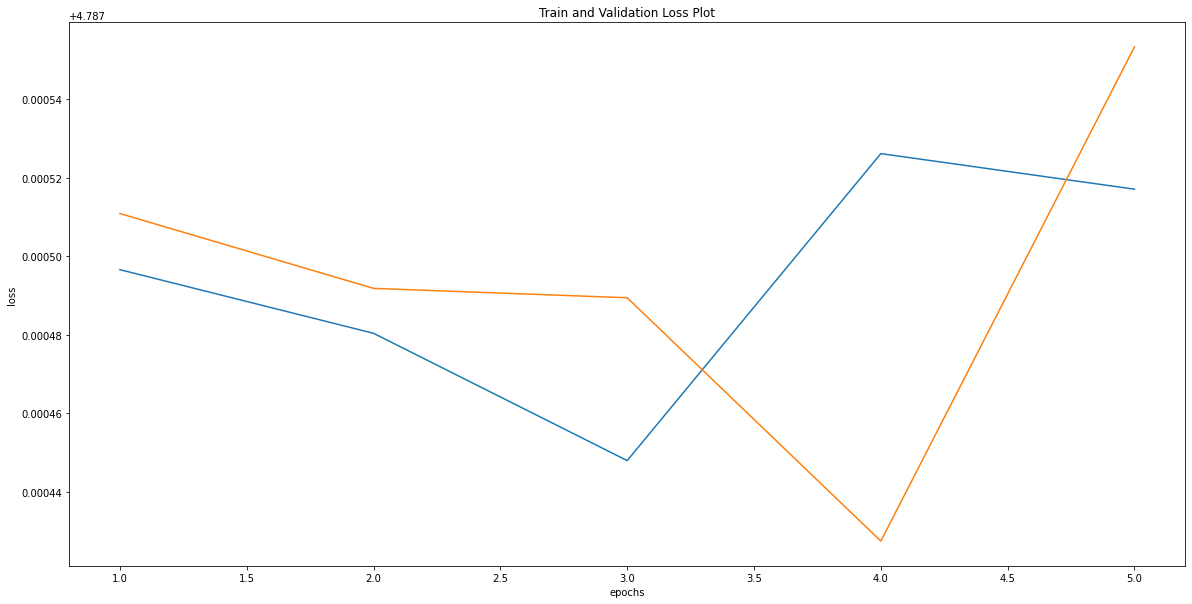

4 4.7875261306762695


In [ ]:
plt.figure(figsize=(20,10))
t = [i.item() for i in train_mean_losses]
plt.plot(range(1,epochs+1), t)
v = [j.item() for j in valid_mean_losses]
plt.plot(range(1,epochs+1), v)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Train and Validation Loss Plot')
plt.show()
max_y = max(t)
max_x = range(1,epochs+1)[t.index(max_y)]
print(max_x, max_y)

We assign the accuracy of the second model to a variable.

In [ ]:
test_acc = 0
net2.eval()

with torch.no_grad():
    for i, (x_batch, y_batch) in enumerate(test_loader):
        out = net2(x_batch)
        _, y_pred = torch.max(out.data, 1)
        test_acc += (y_pred==y_batch).sum().item()

    accuracy2 = round(100*test_acc/len(test_dataset), 8)

We import all the required libraries and functions to hypertune our model. We then create a function which tune our optimizer and report the accuracy to RayTune.

In [ ]:
import ray
from ray import tune, air
from ray.air import session
from ray.tune.search.hyperopt import HyperOptSearch

def objective(config):
    optimizer = torch.optim.SGD(net2.parameters(), lr=config["lr"], momentum=config["momentum"])
    while True:
        session.report({"accuracy": accuracy2})

We define our search space and search algorithm.

In [ ]:
search_space = {"lr": tune.loguniform(1e-4, 1e-2), "momentum": tune.uniform(0.1, 0.9)}
algo = HyperOptSearch()

We tune our model and fit to obtain the configuration.

In [ ]:
tuner = tune.Tuner(
    objective,
    tune_config=tune.TuneConfig(
        metric="accuracy",
        mode="max",
        search_alg=algo,
    ),
    run_config=air.RunConfig(
        stop={"training_iteration": 5},
    ),
    param_space=search_space,
)
results = tuner.fit()
results.get_best_result().config

2022-11-24 09:47:37,311	INFO worker.py:1528 -- Started a local Ray instance.
2022-11-24 09:47:39,858	WARNING function_trainable.py:587 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2022-11-24 09:47:39,901	INFO tensorboardx.py:170 -- pip install "ray[tune]" to see TensorBoard files.
2022-11-24 09:47:39,902	WARNING callback.py:109 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
objective_08e5cdde,0.944056,2022-11-24_09-47-42,True,,83c59188bb224a84886d30fc918a101e,2699f23c6f45,5,172.28.0.2,583,0.0294709,0.00160789,0.0294709,1669283262,0,,5,08e5cdde,0.00419331


2022-11-24 09:47:43,005	INFO tune.py:778 -- Total run time: 3.15 seconds (2.96 seconds for the tuning loop).


{'lr': 0.008783153704093419, 'momentum': 0.6431793628542298}

# **Accuracy and Model Comparison**

We print each accuracy to compare each model.

In [ ]:
print("Model 1 Accuracy =", accuracy1, "%")
print("Model 2 Accuracy before Hypertuning =", accuracy2, "%")
print("Model 2 Accuracy after Hypertuning =", results.get_dataframe().accuracy)

Model 1 Accuracy = 1.10722611 %
Model 2 Accuracy before Hypertuning = 0.94405594 %
Model 2 Accuracy after Hypertuning = 0    0.944056
Name: accuracy, dtype: float64


From the displayed results, we can see that the first model has a higher accuracy, meaning the first model is better in predicting images compared to the second model. Even after hypertuning, there is no significant increase in accuracy of the second model.